#  Train a model with many observables (no external parameter dependence)

In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
from scipy import stats, integrate
from   matplotlib import pyplot as plt, colors

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import histo_to_line, plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename, joint_shuffle

from backends import plot as plot, density_model as density_model, VBFZ_analysis as VBFZ


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [22]:
#  Model config

num_gaussians            = 20
max_epochs               = 500
batch_size               = 1000
early_stopping_patience  = 5
early_stopping_min_delta = 5e-5
validation_split         = -1

gauss_width_factor = 1./4.
batch_norm         = False
dropout            = -1.

learning_rate              = 1e-3
learning_rate_evo_factor   = 0.3
learning_rate_evo_patience = 2
optimiser                  = "adam"


### Define toy model

\begin{equation}
p \left( \vec x \right) ~=~ \prod_{~i~=~0}^{~j~<~{\rm dim} (x)} p \left( x_i | x_{<i} \right)
\end{equation}

In [23]:

alpha_x0, beta_x0, gamma_x0 = 4, 3, 1
f1_x0         = np.exp(2*(alpha_x0*beta_x0+gamma_x0)) / alpha_x0 / (np.exp(2*(alpha_x0*beta_x0+gamma_x0)) - 1) 
int_const_x0  = (alpha_x0*beta_x0 + gamma_x0) * f1_x0
norm_const_x0 = 2 * int_const_x0

def base_prob (x0) :
    return 1. / (1 + np.exp(alpha_x0*(x0-beta_x0)-gamma_x0)) / (1 + np.exp(-alpha_x0*(x0+beta_x0)-gamma_x0)) / norm_const_x0
    
def base_int (x0) :
    f2 = np.exp(alpha_x0*(beta_x0+x0) + gamma_x0) + 1
    f3 = np.exp(alpha_x0*beta_x0 + gamma_x0) + np.exp(alpha_x0*x0)
    return (f1_x0 * np.log( f2 / f3 ) + int_const_x0) / norm_const_x0

def base_inv (I0) :
    L   = np.exp( (I0*norm_const_x0 - int_const_x0) / f1_x0 )
    num = L*np.exp(alpha_x0*beta_x0 + gamma_x0) - 1.
    den = np.exp(alpha_x0*beta_x0 + gamma_x0) - L
    return np.log(num / den) / alpha_x0

def p_x0 (x0) :
    return base_prob (x0) 
    
def int_x0 (x0) :
    return base_int (x0)

def inv_int_x0 (I0) :
    return base_inv (I0)

def p_x1 (x1, x0) :
    x1 = x1 - x0/2.
    return base_prob(x1)
    
def int_x1 (x1, x0) :
    x1 = x1 - x0/2.
    return base_int(x1)

def inv_int_x1 (I1, x0) :
    return x0*2. + base_inv(I1)

def p_x2 (x2) :
    return base_prob (x2) 
    
def int_x2 (x2) :
    return base_int (x2)

def inv_int_x2 (I2) :
    return base_inv (I2)

def p_x3 (x3, x2, x1) :
    x3 = x3 - 0.5*x2 + 0.2*x1*x1
    return base_prob(x3)
    
def int_x3 (x3, x2, x1) :
    x3 = x3 - 0.5*x2 + 0.2*x1*x1
    return base_int(x3)

def inv_int_x3 (I3, x2, x1) :
    return 0.5*x2 - 0.2*x1*x1 + base_inv(I3)

def p_x4 (x4, x3, x2, x1, x0) :
    x4 = x4 - 0.3*x0 - 0.2*x1 - 0.3*x2*x2 - 0.0003*x3*x3*x3
    return base_prob(x4)
    
def int_x4 (x4, x3, x2, x1, x0) :
    x4 = x4 - 0.3*x0 - 0.2*x1 - 0.3*x2*x2 - 0.0003*x3*x3*x3
    return base_int(x4)

def inv_int_x4 (I4, x3, x2, x1, x0) :
    return 0.3*x0 + 0.2*x1 + 0.3*x2*x2 + 0.0003*x3*x3*x3 + base_inv(I4)

def generate (n_pts) :
    u0 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x0 = inv_int_x0(u0)
    u1 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x1 = inv_int_x1(u1, x0)
    u2 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x2 = inv_int_x2(u2)
    u3 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x3 = inv_int_x3(u3, x2, x1)
    u4 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x4 = inv_int_x4(u4, x3, x2, x1, x0)
    return np.array([x0, x1, x2, x3, x4]).transpose()

datapoints      = generate(1e5)
datapoints_dict = {1.: datapoints}
weights_dict    = {1.: np.ones(shape=(len(datapoints),))}

num_observables = datapoints.shape[1]


#  Build and fit the density model


In [24]:
#  Define callback class

from keras.callbacks import Callback
import tensorflow as tf

class ModelCheckpoint (Callback) :

    def __init__(self, cond_vals=[1.], obs_vals=[0., 0., 0., -15.]):
        super(ModelCheckpoint, self).__init__()
        self.cond_vals = np.array(cond_vals).reshape(1, 1)
        self.obs_vals  = np.array(obs_vals).reshape(1, 4)

    def on_train_begin(self, logs=None):
        self.model.record = []
        self.model.record.append(self.model.predict([self.cond_vals, self.obs_vals])[0])

    def on_epoch_end(self, epoch, logs=None):
        self.model.record.append(self.model.predict([self.cond_vals, self.obs_vals])[0])
        

In [25]:
#===========================
#===   BUILD&FIT MODEL   ===
#===========================


#
#   Figure out the limits of the observables
#
obs_lims = []
for obs_idx in range(num_observables) :     
    min_dp, max_dp     = np.min(datapoints[:,obs_idx]), np.max(datapoints[:,obs_idx])
    range_dp_per_gauss = (max_dp - min_dp) / num_gaussians
    obs_lims.append([min_dp + 0.5*range_dp_per_gauss, max_dp - 0.5*range_dp_per_gauss]) 
density_model = DensityModel(name               = "Toy_density_model"  , 
                             num_gaussians      = num_gaussians        , 
                             num_conditions     = 1                    , 
                             num_observables    = num_observables      ,
                             observables_limits = obs_lims             ,
                             verbose            = True                 , 
                             gauss_width_factor = gauss_width_factor   ,
                             gauss_mean_scale   = 1./100.              ,
                             gauss_frac_scale   = 1./100.              ,
                             gauss_sigma_scale  = 1./100.              ,
                             optimiser          = optimiser            ,
                             learning_rate      = learning_rate        ,
                             A1                 = 200                  ,
                             A2                 = 0                    ,
                             B1                 = 200                  ,
                             B2                 = 50                   ,
                             C_float            = 2                    ,
                             D2                 = 3                    ,
                             batch_norm         = batch_norm           ,
                             dropout            = dropout              )
#
#   Make sure initial state has no NaN/Inf loss
#
density_model.ensure_valid_over_dataset (datapoints_dict, weights_dict)


No observable types argument provided - assuming all are floats
INFO       DensityModel.construct      Set model name              : Toy_density_model
INFO       DensityModel.construct      Set model num_gaussians     : 20
INFO       DensityModel.construct      Set model num_conditions    : 1
INFO       DensityModel.construct      Set model num_observables   : 5
INFO       DensityModel.construct      Set observable types        : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set learning_rate_evo_factor: 1.0
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.0
INFO       DensityModel.constru

Model: "Toy_density_model_observable1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_140 (Lambda)             (None, 1)            0           input_30[0][0]                   
__________________________________________________________________________________________________
dense_156 (Dense)               (None, 200)          400         input_29[0][0]                   
______________________________________________________________________

Model: "Toy_density_model_observable3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_158 (Lambda)             (None, 3)            0           input_34[0][0]                   
__________________________________________________________________________________________________
dense_176 (Dense)               (None, 200)          400         input_33[0][0]                   
______________________________________________________________________

Model: "Toy_density_model_observable4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_167 (Lambda)             (None, 4)            0           input_36[0][0]                   
__________________________________________________________________________________________________
dense_186 (Dense)               (None, 200)          400         input_35[0][0]                   
______________________________________________________________________

In [26]:
#
#   Fit all but last observable
#
density_model.fit(datapoints_dict                                        ,
                  weights_dict                                           ,
                  observable                 = [0, 1, 2, 3]              ,
                  max_epochs_per_observable  = max_epochs                ,
                  early_stopping_patience    = early_stopping_patience   ,
                  early_stopping_min_delta   = early_stopping_min_delta  ,
                  validation_split           = validation_split          ,
                  batch_size_per_observable  = batch_size                ,
                  learning_rate_evo_factor   = learning_rate_evo_factor  ,
                  learning_rate_evo_patience = learning_rate_evo_patience)

INFO       DensityModel.fit            Queued the following observable indices to train: 0, 1, 2, 3
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 500
INFO       DensityModel.fit              -  Training setting: batch_size = 1000
INFO       DensityModel.fit              -  Training setting: validation_split = -1
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 5
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 1e-06
Train on 100000 samples
Epoch 1/500
100000/100000 [==============================] - 2s 19us/sample - loss: 2.0856
Epoch 2/500
100000/100000 [==============================] - 2s 16us/sample - loss: 2.0016
Epoch 3/500
100000/100000 [==============================] - 2s 16us/sample - loss: 2.0008
Epoch 4/500
100000/100000 [========================

100000/100000 [==============================] - 4s 39us/sample - loss: 1.9976
Epoch 37/500
100000/100000 [==============================] - 2s 21us/sample - loss: 1.9976
Epoch 38/500
100000/100000 [==============================] - 2s 24us/sample - loss: 1.9976
Epoch 39/500
100000/100000 [==============================] - 4s 40us/sample - loss: 1.9976
Epoch 40/500
100000/100000 [==============================] - 2s 21us/sample - loss: 1.9975
Epoch 41/500
100000/100000 [==============================] - 2s 24us/sample - loss: 1.9975
Epoch 42/500
100000/100000 [==============================] - 2s 24us/sample - loss: 1.9975
Epoch 43/500
100000/100000 [==============================] - 2s 24us/sample - loss: 1.9975
Epoch 44/500
100000/100000 [==============================] - 2s 23us/sample - loss: 1.9975
Epoch 45/500
100000/100000 [==============================] - 4s 39us/sample - loss: 1.9975
Epoch 46/500
100000/100000 [==============================] - 2s 21us/sample - loss: 1.9975
E

In [27]:
#
#   Fit last observable
#
density_model.fit(datapoints_dict                                        ,
                  weights_dict                                           ,
                  observable = 4                                         ,
                  max_epochs_per_observable = max_epochs                 ,
                  early_stopping_patience   = early_stopping_patience    ,
                  early_stopping_min_delta  = early_stopping_min_delta   ,
                  validation_split          = validation_split           ,
                  batch_size_per_observable = batch_size                 ,
                  callbacks                 = [ModelCheckpoint()]        ,
                  learning_rate_evo_factor   = learning_rate_evo_factor  ,
                  learning_rate_evo_patience = learning_rate_evo_patience)


INFO       DensityModel.fit            Queued the following observable indices to train: 4
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 4
INFO       DensityModel.fit              -  Training setting: epochs = 500
INFO       DensityModel.fit              -  Training setting: batch_size = 1000
INFO       DensityModel.fit              -  Training setting: validation_split = -1
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 5
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 1e-06
Train on 100000 samples
Epoch 1/500
100000/100000 [==============================] - 4s 35us/sample - loss: 2.2719
Epoch 2/500
100000/100000 [==============================] - 3s 32us/sample - loss: 2.03560s - los
Epoch 3/500
100000/100000 [==============================] - 4s 38us/sample - loss: 2.0195
Epoch 4/500
100000/100000 [=========================

100000/100000 [==============================] - 4s 41us/sample - loss: 1.9952
Epoch 171/500
100000/100000 [==============================] - 6s 56us/sample - loss: 1.9952
Epoch 172/500
100000/100000 [==============================] - 3s 34us/sample - loss: 1.9952
Epoch 173/500
100000/100000 [==============================] - 4s 37us/sample - loss: 1.9952
Epoch 174/500
100000/100000 [==============================] - 5s 54us/sample - loss: 1.9952
Epoch 175/500
100000/100000 [==============================] - 3s 32us/sample - loss: 1.9952
Epoch 176/500
100000/100000 [==============================] - 4s 36us/sample - loss: 1.9952
Epoch 177/500
100000/100000 [==============================] - 6s 56us/sample - loss: 1.9952
Epoch 178/500
100000/100000 [==============================] - 3s 34us/sample - loss: 1.9952
Epoch 179/500
100000/100000 [==============================] - 4s 36us/sample - loss: 1.9952
Epoch 180/500
100000/100000 [==============================] - 5s 54us/sample - loss

KeyboardInterrupt: 

In [28]:
#  Generate a large number of datapoints at 0.
#

n_gen = int(1e6)

print(f"Generating {n_gen} fake datapoints")
start = time.time()
fake_datapoints = density_model.sample(n_gen, [1.], n_processes=8)
end = time.time()
print(f"{n_gen} datapoints generated in {int(end-start):.0f}s")


Generating 1000000 fake datapoints
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 4
1000000 datapoints generated in 430s


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:183: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:184: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:185: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:185: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1


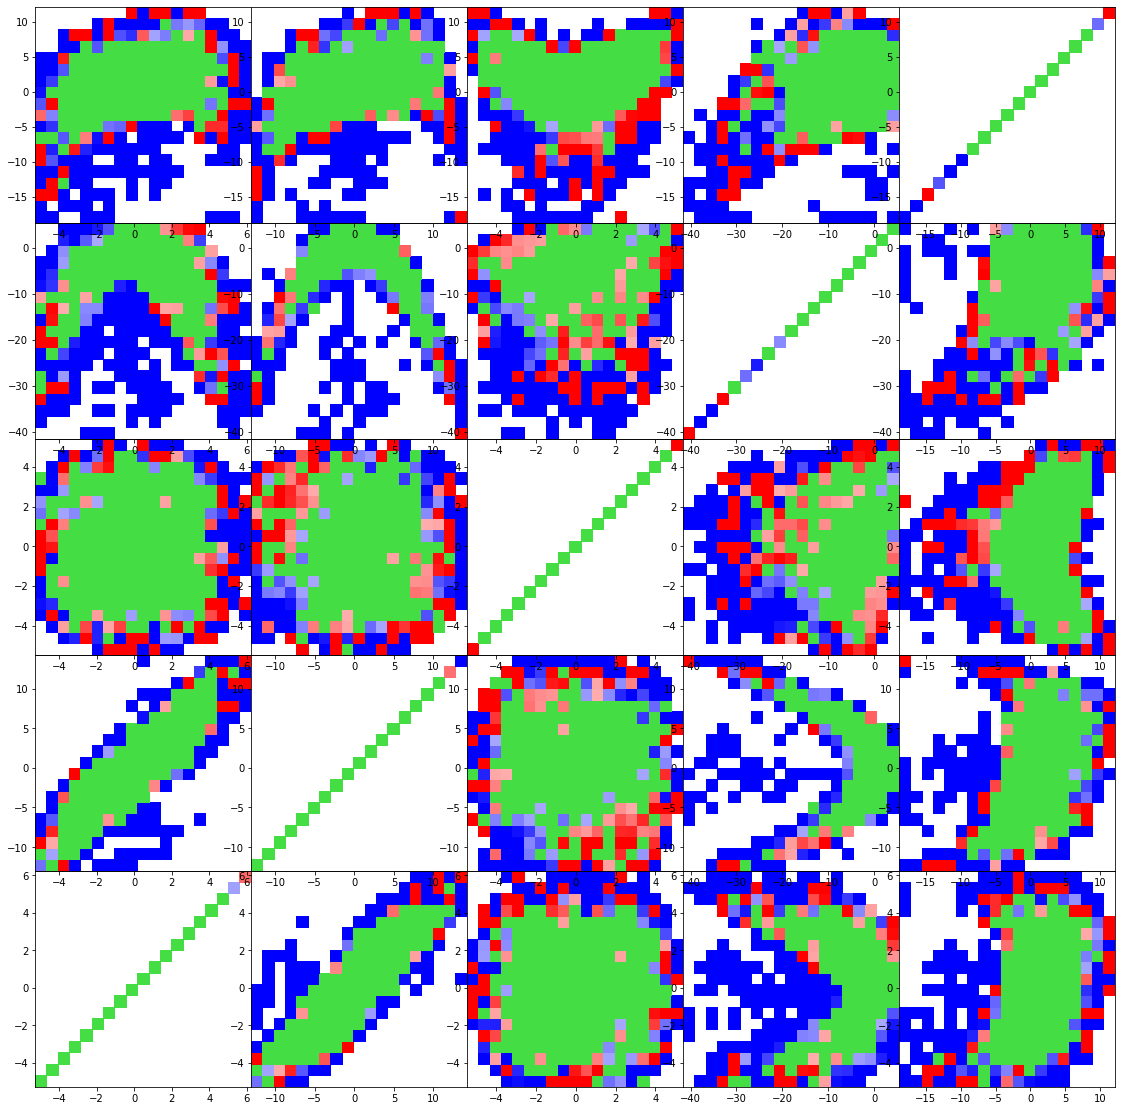

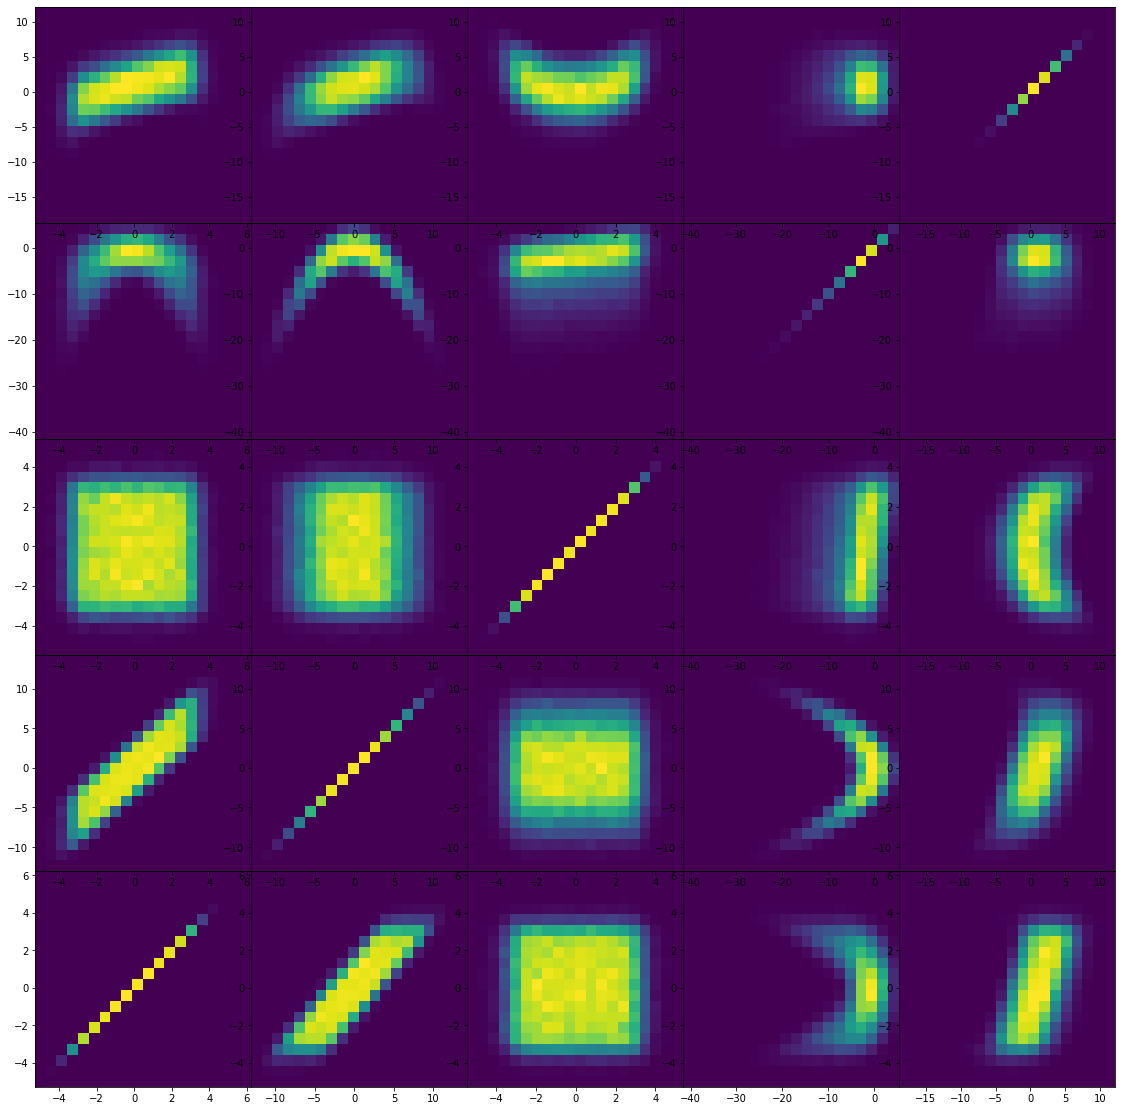

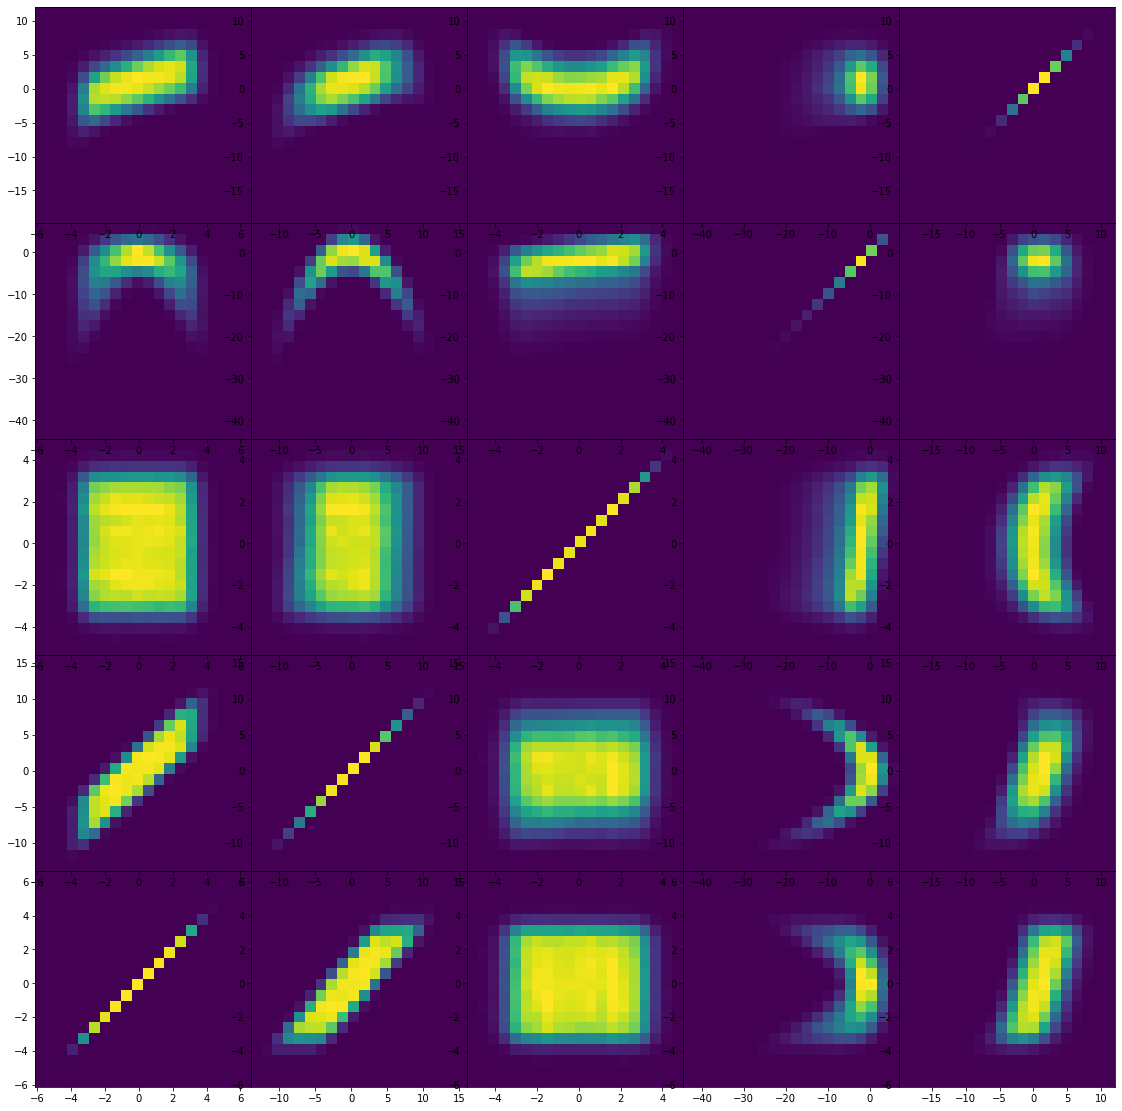

In [29]:
#  Plot

import math
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap_bwr  = cm.get_cmap('bwr', 256)
newcolors = cmap_bwr(np.linspace(0, 1, 256))
newcolors [math.ceil(256*2/6)-1:math.floor(256*4/6)-1] = np.array([68/256, 223/256, 68/256, 1])
custom_colormap = ListedColormap(newcolors, name='BlueToRed')

def plot_2d (dps) :
    fig = plt.figure(figsize=(3*num_observables, 3*num_observables))
    for obs_idx_x in range(num_observables) :
        for obs_idx_y in range(num_observables) :
            ax = fig.add_axes([obs_idx_x/num_observables, obs_idx_y/num_observables, 1./num_observables, 1./num_observables])
            ax.hist2d(dps[:,obs_idx_x], dps[:,obs_idx_y], bins=20)
    plt.show()
    
    
def plot_2d_ratios (dps_num, dps_den, num_bins=20) :
    fig = plt.figure(figsize=(3*num_observables, 3*num_observables))
    for obs_idx_x in range(num_observables) :
        for obs_idx_y in range(num_observables) :
            ax = fig.add_axes([obs_idx_x/num_observables, obs_idx_y/num_observables, 1./num_observables, 1./num_observables])
            bins_x = np.linspace(np.min(dps_den[:,obs_idx_x]), np.max(dps_den[:,obs_idx_x]), num_bins)
            bins_y = np.linspace(np.min(dps_den[:,obs_idx_y]), np.max(dps_den[:,obs_idx_y]), num_bins)
            X, Y, ratio, ratio_err = plot.get_ratio_2D (dps_num[:,obs_idx_x], dps_num[:,obs_idx_y],
                                                        dps_den[:,obs_idx_x], dps_den[:,obs_idx_y],
                                                        bins_x, bins_y)            
            im = ax.pcolormesh(X, Y, ratio.transpose()-1, cmap=custom_colormap, vmin=-0.3, vmax=0.3)
    '''cbar_ax = fig.add_axes([1.05, 0.5, 0.03, 0.45])
    cbar    = fig.colorbar(im, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=14)
    cbar   .set_ticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])
    cbar   .set_label(r"$\frac{p(x)}{{\rm max}~p(x)}$", fontsize=25, labelpad=50, rotation=0, va="center")'''
    plt.show()
    
    
plot_2d_ratios(fake_datapoints, datapoints)
plot_2d(datapoints)
plot_2d(fake_datapoints)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide


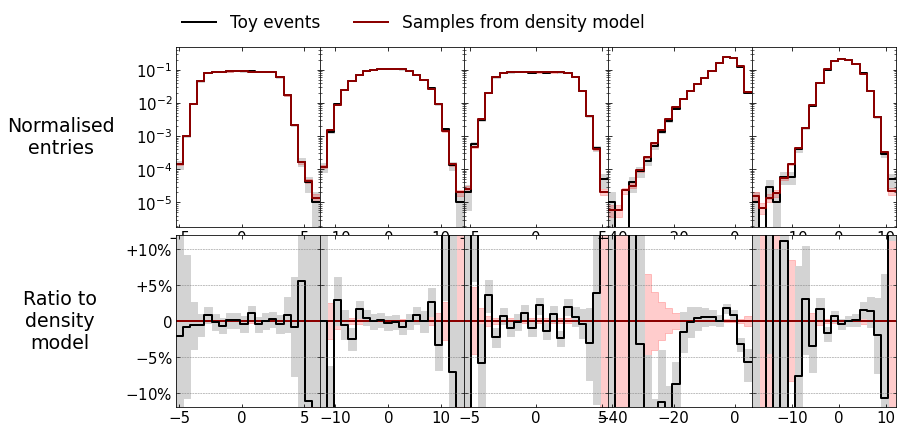

In [30]:
##  TODO: Fix tick marks on y-axis

observable_limits = []
for obs_idx in range(num_observables) :     
    observable_limits.append([np.min(datapoints[:,obs_idx]), np.max(datapoints[:,obs_idx])]) 

def plot_1D (true_data, fake_data, num_bins=20) :
    
    fig = plt.figure(figsize=(2*num_observables, 5))

    axes1, axes2 = [], []
    ylos , yhis  = [], []

    for obs_idx in range(num_observables) :

        #  Get axis x coordinates
        xlo    = obs_idx / num_observables
        xwidth = 1.      / num_observables

        #  ============
        #     AXIS 1
        #  ============
        ax1 = fig.add_axes([xlo, 0.50, xwidth, 0.5])

        obs_lims = observable_limits[obs_idx]
        bins     = np.linspace(obs_lims[0], obs_lims[1], num_bins+1)

        hvals1, _ = np.histogram(true_data[:,obs_idx], bins=bins)
        herrs1    = np.sqrt(hvals1)
        hvals1, herrs1 = hvals1/np.sum(hvals1), herrs1/np.sum(hvals1)

        hvals2, _ = np.histogram(fake_data[:,obs_idx], bins=bins)
        herrs2    = np.sqrt(hvals2)
        hvals2, herrs2 = hvals2/np.sum(hvals2), herrs2/np.sum(hvals2)

        plot_x, plot_y1, plot_ey1 = plot.histo_to_line(bins, hvals1, herrs1)
        _     , plot_y2, plot_ey2 = plot.histo_to_line(bins, hvals2, herrs2)

        ax1.plot(plot_x, plot_y1, "-", color="k"      , linewidth=2, label="Toy events")
        ax1.fill_between(plot_x, plot_y1-plot_ey1, plot_y1+plot_ey1, color="lightgrey", alpha=1)
        ax1.plot(plot_x, plot_y2, "-", color="darkred", linewidth=2, label="Samples from density model")
        ax1.fill_between(plot_x, plot_y2-plot_ey2, plot_y2+plot_ey2, color="red", alpha=0.2)
        ax1.set_yscale("log")

        # Save y values range
        ylo, yhi = np.concatenate([plot_y1-plot_ey1, plot_y2-plot_ey2]), np.concatenate([plot_y1+plot_ey1, plot_y2+plot_ey2])
        ylos.append(np.min([y for y in ylo if y > 0]))
        yhis.append(np.max([y for y in ylo if y > 0]))


        #  ============
        #     AXIS 2
        #  ============

        ax2 = fig.add_axes([xlo, 0, xwidth, 0.48])

        ax2.axhline(0, c="darkred", linewidth=2)
        ax2.fill_between(plot_x, -plot_ey2/plot_y2, plot_ey2/plot_y2, color="red", alpha=0.2)
        ax2.plot(plot_x, (plot_y1-plot_y2)/plot_y2, c="k", linewidth=2)
        ax2.fill_between(plot_x, (plot_y1-plot_ey1-plot_y2)/plot_y1, (plot_y1+plot_ey1-plot_y2)/plot_y1, color="lightgrey", alpha=1)
        ax2.set_ylim([-0.12, 0.12])

        for h in [-0.1, -0.05, 0.05, 0.1] :
            ax2.axhline(h, linestyle="--", c="grey", linewidth=0.5)

        #  Set y axis tick labels    
        if obs_idx > 0 :
            ax1.get_yaxis().set_ticklabels([])
            ax2.get_yaxis().set_ticklabels([])

        #  Set y axis labels
        if obs_idx == 0 : 
            ax1.set_ylabel("Normalised\nentries", fontsize=19, labelpad=75, rotation=0, va="center")
            ax2.set_ylabel("Ratio to\ndensity\nmodel", fontsize=19, labelpad=65, rotation=0, va="center")
            ax1.legend(loc=(0, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=17)

        #  Set x limits
        ax1.set_xlim([bins[0], bins[-1]])
        ax2.set_xlim([bins[0], bins[-1]])

        #  Set tick params
        ax1.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
        ax2.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)

        #  Save axes
        axes1.append(ax1)
        axes2.append(ax2)

    #  Set consistent axis y lims
    for ax in axes1 :
        ax.set_ylim([np.min(ylos)/2., 2.*np.max(yhis)])

    axes2[0].set_yticks     ([-0.1, -0.05, 0, 0.05, 0.1])
    axes2[0].set_yticklabels([r"$-10\%$", r"$-5\%$", r"$0$", r"$+5\%$", r"$+10\%$"])

    
plot_1D(datapoints, fake_datapoints)


Warning - ContinuousDensityModel.evaluate is deprecated (please use DensityModel.evaluate)


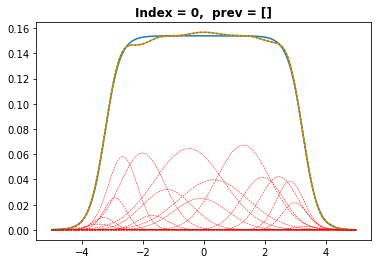

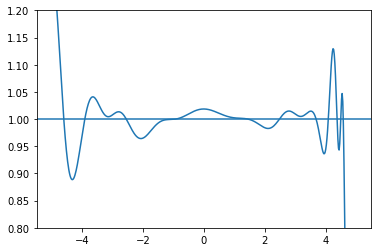

Warning - ContinuousDensityModel.evaluate is deprecated (please use DensityModel.evaluate)


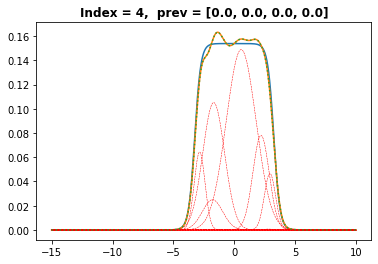

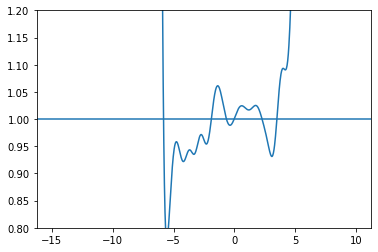

Warning - ContinuousDensityModel.evaluate is deprecated (please use DensityModel.evaluate)


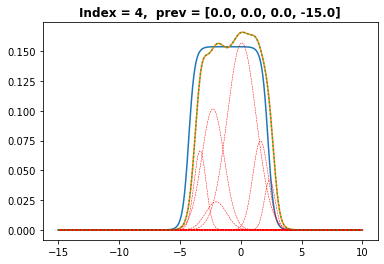

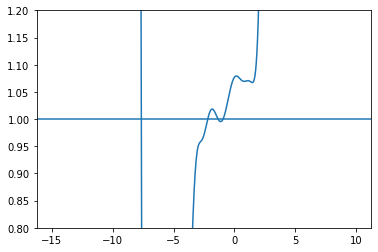

In [31]:
#  Study model description for (0, 0, 0, -15, x4)

def plot_curves (index, prev=[]) :
    
    x = np.linspace(-5, 5, 501)
    if index == 4 : x = np.linspace(-15, 10, 1001)
        
    if index == 0 :
        params  = density_model.likelihood_models[0].get_gauss_params([1.])[0]
        y_model = density_model.likelihood_models[0].evaluate(x, [1.])
    else :
        xl      = np.full(shape=(len(x), index), fill_value=prev)
        params  = density_model.likelihood_models[4].get_gauss_params([[1.] for i in range(len(x))], xl)[0]
        y_model = density_model.likelihood_models[4].evaluate(x, [1.], xl)
    
    fracs  = params[:num_gaussians]
    means  = params[num_gaussians:2*num_gaussians]
    sigmas = params[2*num_gaussians:3*num_gaussians]

    if index == 0 : y_true  = p_x0(x)
    if index == 4 : y_true  = p_x4(x, xl[:,3], xl[:,2], xl[:,1], xl[:,0])

    plt.plot(x, y_true)
    plt.plot(x, y_model)
    y_model2 = 0.
    for i in range(num_gaussians) :
        gauss_pdf = fracs[i]*stats.norm.pdf(x, loc=means[i], scale=sigmas[i])
        plt.plot(x, gauss_pdf, "--", c="r", lw=0.5)
        y_model2 += gauss_pdf
    plt.plot(x, y_model2, ":")
    plt.gca().set_title(f"Index = {index},  prev = {prev}", weight="bold")
    plt.show()

    plt.plot(x, y_model/y_true)
    plt.gca().axhline(1)
    plt.gca().set_ylim([0.8, 1.2])
    plt.show()

plot_curves(0)
plot_curves(4, [0., 0., 0., 0.])
plot_curves(4, [0., 0., 0., -15.])

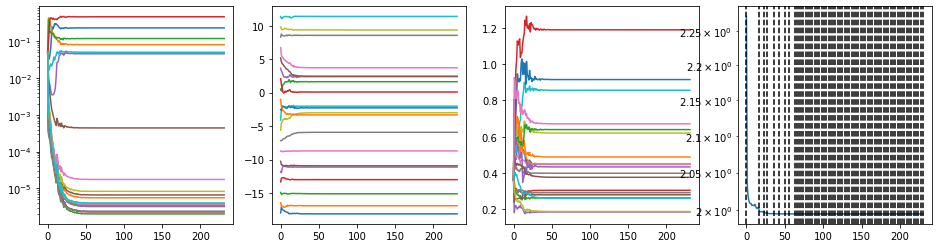

In [33]:
#  Study model evolution for (0, 0, 0, -15, x4)

model         = density_model.likelihood_models[4].model
params_record = model.record

fracs  = [[] for i in range(num_gaussians)]
means  = [[] for i in range(num_gaussians)]
sigmas = [[] for i in range(num_gaussians)]

for params in params_record :
    for i, frac  in enumerate(params[:num_gaussians]                 ) : fracs [i].append(frac)
    for i, mean  in enumerate(params[num_gaussians  :2*num_gaussians]) : means [i].append(mean)
    for i, sigma in enumerate(params[2*num_gaussians:3*num_gaussians]) : sigmas[i].append(sigma)

fig = plt.figure(figsize=(16, 4))
ax  = fig.add_subplot(1, 4, 1)
for frac in fracs :
    ax.plot(frac)
ax.set_yscale("log")
ax  = fig.add_subplot(1, 4, 2)
for mean in means :
    ax.plot(mean)
ax  = fig.add_subplot(1, 4, 3)
for sigma in sigmas :
    ax.plot(sigma)
ax  = fig.add_subplot(1, 4, 4)
ax.plot(model.monitor_record)
#ax.set_ylim([1.99, 2.03])
for (epoch, new_lr) in model.lr_record :
    ax.axvline(epoch, ls="--", c="k")
ax.set_yscale("log")
plt.show()
